# **Imports:**
### In this step, necessary libraries for data manipulation, image processing, model building, and evaluation are imported.
### The dataset is then downloaded from Kaggle for further processing and analysis.

In [1]:
# === Standard Libraries ===
import os
import random
import hashlib
import warnings

# === Data Analysis & Visualization ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Image Processing ===
import cv2
from PIL import Image
from skimage import exposure, filters, color
from skimage.feature import hog

# === Progress Bar ===
from tqdm.notebook import tqdm

# === Scikit-Learn ===
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# === TensorFlow / Keras ===
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


# Ignore warnings
warnings.filterwarnings('ignore')

# Import the dataset from Kaggle
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

100%|██████████| 65.2M/65.2M [00:03<00:00, 19.0MB/s]

Extracting files...


# **Data Loading:**

### In this step, the images and their corresponding labels are loaded from the dataset folder.
### The data is then shuffled to ensure random distribution, and it is split into training,
### validation, and test sets to prepare for model training and evaluation.


In [2]:
def load_dataset(directory):
    """
    Loads images and labels from the folder.

    Arguments:
    directory (str): Path to the main folder of the dataset.

    Returns:
    image_paths (list): A list of paths to the images.
    labels (list): A list of labels corresponding to each image.
    """
    image_paths = []
    labels = []

    for label in os.listdir(directory): # Open the dir of each label
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):  # Loop over files in label folder
                image_path = os.path.join(label_path, filename)
                image_paths.append(image_path)
                labels.append(label)

    return image_paths, labels

# Path to the dataset directories
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

# Convert train data into DataFrame
train = pd.DataFrame()
train['image path'], train['label'] = load_dataset(train_dir)

# Shuffle the dataset before splitting
train_df = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert test data into DataFrame
test = pd.DataFrame()
test['image path'], test['label'] = load_dataset(test_dir)

# Reset index for test data
test = test.reset_index(drop=True)

# Display one example image for each emotion
unique_labels = train['label'].unique()

# Display first few rows of train DataFrame for verification
print("\nTrain DataFrame for example:")
train_df.head()


Train DataFrame for example:


,image path,label
0,/root/.cache/kagglehub/datasets/ananthu017/emo...,angry
1,/root/.cache/kagglehub/datasets/ananthu017/emo...,happy
2,/root/.cache/kagglehub/datasets/ananthu017/emo...,sad
3,/root/.cache/kagglehub/datasets/ananthu017/emo...,angry
4,/root/.cache/kagglehub/datasets/ananthu017/emo...,sad


# **EDA - Exploratory Data Analysis:**

## Initial analysis of the data:

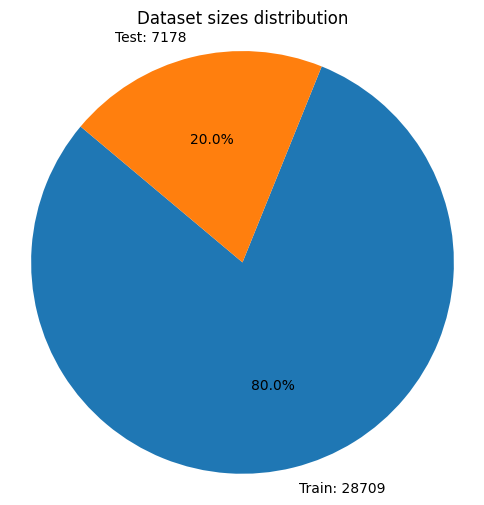

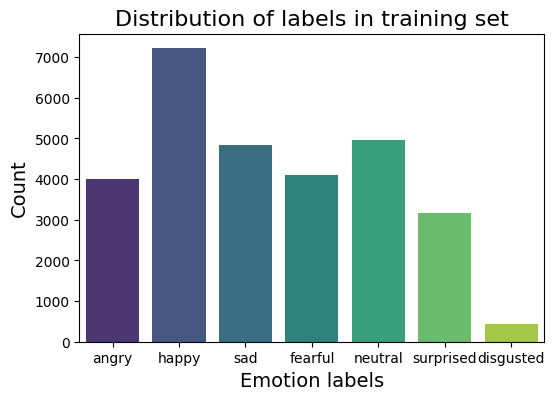

In [3]:
# Dataset sizes
dataset_sizes = [len(train_df), len(test)]
dataset_labels = ['Train', 'Test']

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(dataset_sizes, labels=[f"{label}: {size}" for label, size in zip(dataset_labels, dataset_sizes)], autopct='%1.1f%%', startangle=140)
plt.title('Dataset sizes distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Print a plot that visualizes the distribution of emotion labels in the train dataset.
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='label', palette='viridis')
plt.xticks(rotation=0)
plt.title("Distribution of labels in training set", fontsize=16)
plt.xlabel("Emotion labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()


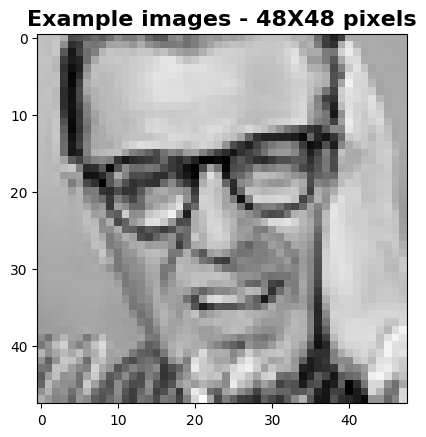

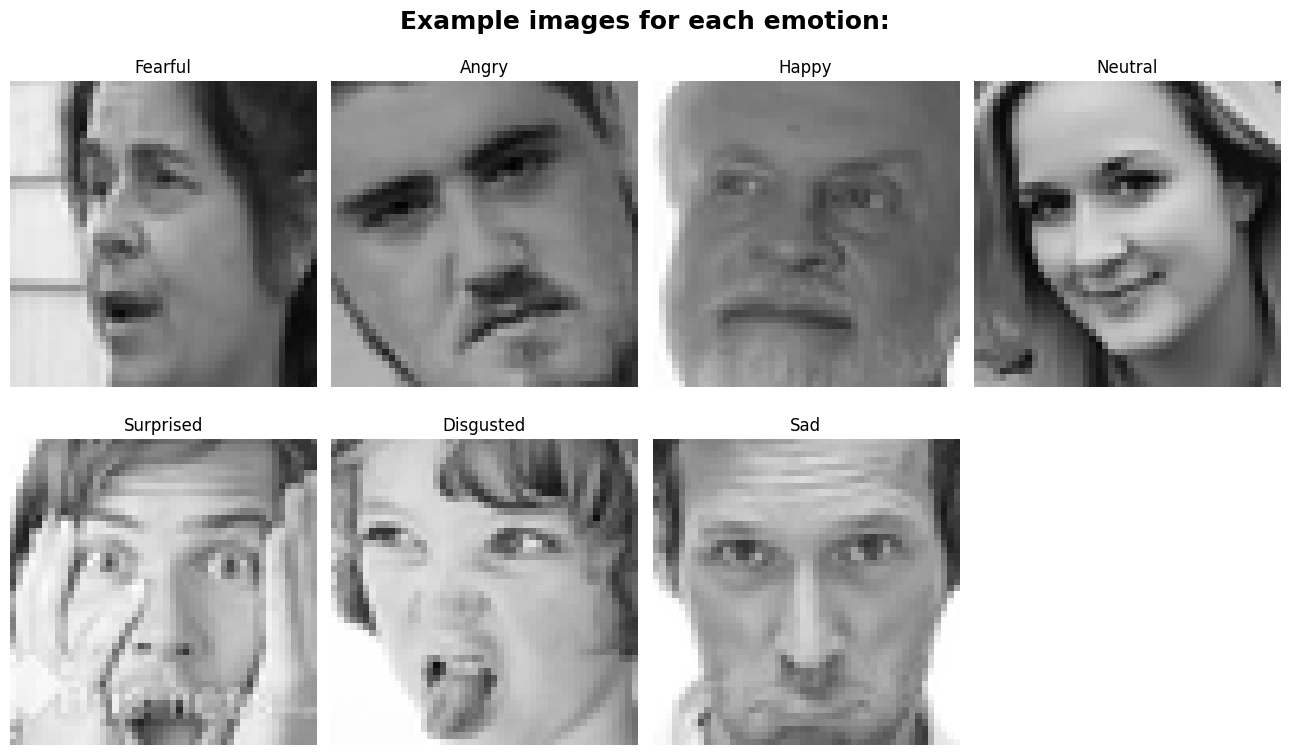

In [4]:
# display one photo for example
img = Image.open(train_df['image path'][0])
plt.imshow(img, cmap='gray')

# Add the title to the plot
plt.title("Example images - 48X48 pixels", fontsize=16, weight='bold')
plt.show()

# Print one example for each emotion
plt.figure(figsize=(13, 8))

for i, label in enumerate(unique_labels):
    # Get the first image path for the current label
    image_path = train[train['label'] == label]['image path'].iloc[0]

    # Load and convert the image to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Add subplot for each emotion
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(label.capitalize())  # Capitalize the label for display
    plt.axis('off')

# Add a title to the entire plot
plt.suptitle("Example images for each emotion:", fontsize=18, weight='bold')
plt.tight_layout()
plt.show()

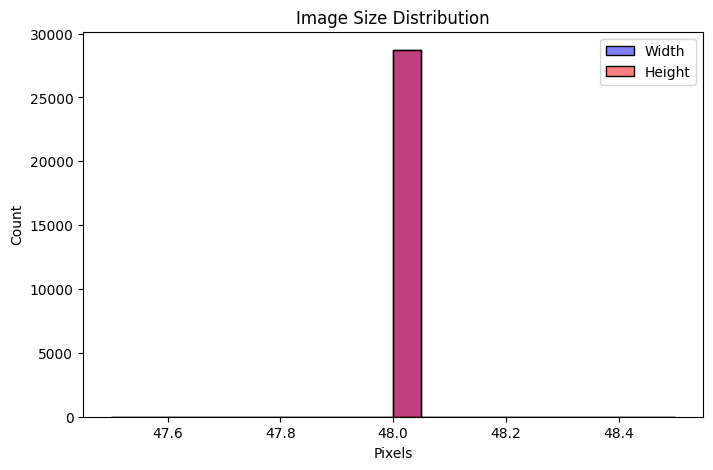

In [5]:
# Analyze the distribution of image widths and heights in the training dataset
image_shapes = [Image.open(img).size for img in train_df['image path']]
widths, heights = zip(*image_shapes)

plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=20, kde=True, color='blue', label='Width')
sns.histplot(heights, bins=20, kde=True, color='red', label='Height')
plt.legend()
plt.title("Image Size Distribution")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.show()

Processing Brightness & Contrast:   0%|          | 0/28709 [00:00<?, ?it/s]

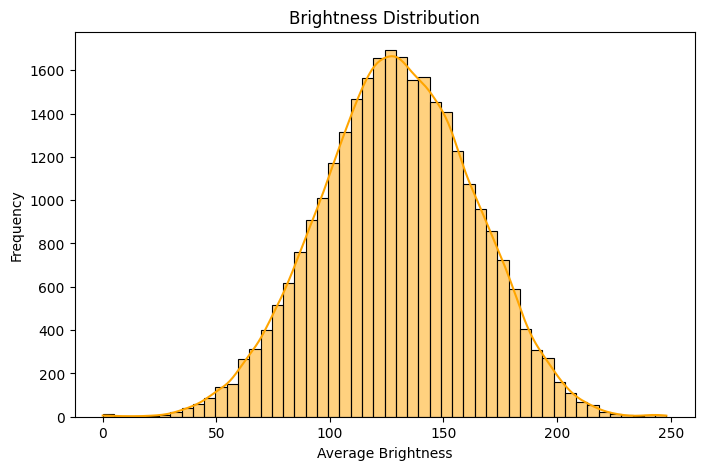

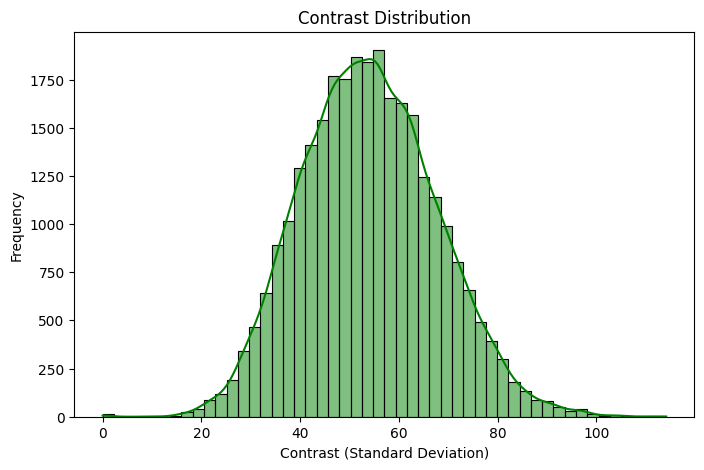

In [6]:
# Calculate and visualize the brightness and contrast distributions of images in the training dataset.
brightness_values = []
contrast_values = []

# Loop through each image path and compute average brightness and standard deviation (contrast)
for img_path in tqdm(train_df['image path'], desc="Processing Brightness & Contrast"):
    img = np.array(Image.open(img_path))
    brightness_values.append(np.mean(img))     # Average brightness per image
    contrast_values.append(np.std(img))        # Standard deviation as a measure of contrast

# Plot brightness distribution
plt.figure(figsize=(8, 5))
sns.histplot(brightness_values, bins=50, kde=True, color='orange')
plt.title("Brightness Distribution")
plt.xlabel("Average Brightness")
plt.ylabel("Frequency")
plt.show()

# Plot contrast distribution
plt.figure(figsize=(8, 5))
sns.histplot(contrast_values, bins=50, kde=True, color='green')
plt.title("Contrast Distribution")
plt.xlabel("Contrast (Standard Deviation)")
plt.ylabel("Frequency")
plt.show()

Analysis of the Histograms
1. Brightness Distribution Histogram
The brightness values are approximately normally distributed, centered around 120-140.
There is a wide range of brightness levels, indicating that some images are darker while others are significantly brighter.
Very few images have extreme brightness values (close to 0 or 250), suggesting that most images are well-balanced in terms of brightness.
Since the dataset covers a broad range of brightness levels, contrast adjustments might be needed to improve model performance, especially if the model struggles to differentiate emotions due to lighting variations.
2. Contrast Distribution Histogram
The contrast (standard deviation of pixel intensity) follows a bell-shaped distribution, meaning that most images have a moderate level of contrast.
The peak is around 50-60, suggesting that most images have distinguishable light and dark areas but are not highly contrasted.
There are few images with very low contrast (below 20), which might indicate blurry or washed-out images.
There are also some high-contrast images (>80), which could be useful for identifying sharp facial features.

## Anomaly detection:

In [7]:
def check_corrupt_images(image_paths):
    corrupt_images = []
    for img_path in tqdm(image_paths, desc="Checking corrupt images"):
        try:
            img = Image.open(img_path)
            img.verify()  # Verify if the image is valid
        except (IOError, SyntaxError):
            corrupt_images.append(img_path)

    return corrupt_images

# Check for corrupted images in training and test sets
corrupt_train = check_corrupt_images(train_df['image path'])
corrupt_test = check_corrupt_images(test['image path'])

# Print the results
print(f"Found {len(corrupt_train)} corrupt images in training set.")
print(f"Found {len(corrupt_test)} corrupt images in test set.")

# Remove corrupt images from DataFrames
train_df = train_df[~train_df['image path'].isin(corrupt_train)]
test = test[~test['image path'].isin(corrupt_test)]

Checking corrupt images:   0%|          | 0/28709 [00:00<?, ?it/s]

Checking corrupt images:   0%|          | 0/7178 [00:00<?, ?it/s]

Found 0 corrupt images in training set.
Found 0 corrupt images in test set.


Found 2271 duplicate images.
Displaying duplicate images with path: /root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train/surprised/im3031.png


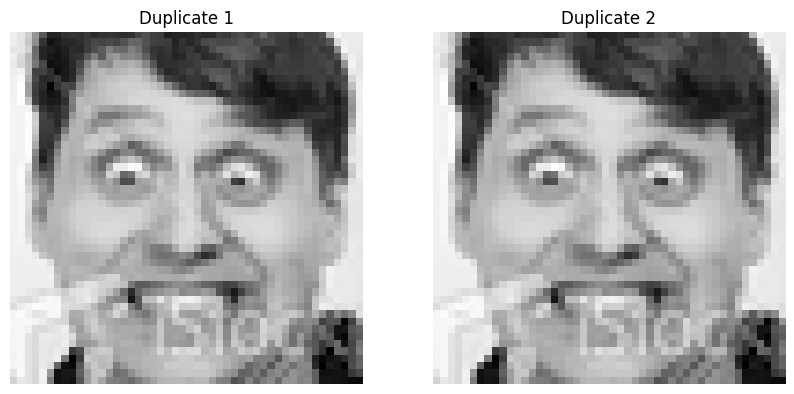

After removal, the training set contains 27473 images.


In [8]:
# Function to compute hash of an image
def get_hash(image_path):
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Add hash column to each image
train_df['hash'] = train_df['image path'].apply(get_hash)

# Identify duplicate images based on hash
duplicate_hashes = train_df[train_df.duplicated(subset=['hash'], keep=False)]

# Print number of duplicate images found
print(f"Found {len(duplicate_hashes)} duplicate images.")

# Visualize example duplicates
if not duplicate_hashes.empty:
    example_hash = duplicate_hashes['hash'].values[0]
    duplicate_paths = duplicate_hashes[duplicate_hashes['hash'] == example_hash]['image path'].values[:2]  # Take 2 examples

    print(f"Displaying duplicate images with path: {duplicate_paths[0]}")

    # Display the duplicate images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, path in enumerate(duplicate_paths):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Duplicate {i+1}")

    plt.show()

# Remove duplicate images by keeping the first occurrence
train_df = train_df.drop_duplicates(subset=['hash'], keep='first').drop(columns=['hash'])

# Print number of images after removing duplicates
print(f"After removal, the training set contains {len(train_df)} images.")

Why This Approach is Necessary?
1. Identifying Truly Problematic Images
Not all anomalous images are necessarily bad for the model.
Some anomalies may still contain useful facial features, while others might be completely uninformative.
By focusing on two specific conditions, we ensure that only truly problematic images are removed:
Too dark & low contrast → Likely no useful facial details.
Too bright & high contrast → May result from over-processing or poor lighting.
2. Preventing Unnecessary Data Loss
If we simply remove all anomalous images, we risk losing important variations in facial expressions.
By visualizing the images first, we can manually verify whether they truly lack useful information before removal.
3. Improving Model Performance
Removing unusable images can reduce noise in the training data.
This ensures the model focuses on meaningful variations rather than trying to learn from bad-quality images.
The remaining anomalies (not removed) can still be used after preprocessing (e.g., contrast enhancement) if needed.
4. Structured Data Cleaning Process
Instead of applying a "one-size-fits-all" deletion, we use clear, measurable conditions (brightness & contrast thresholds).
This approach balances data quality while minimizing unnecessary losses.


In [9]:
brightness_values = []
contrast_values = []

# Loop through each image path and compute brightness (mean) and contrast (std)
for img_path in tqdm(train_df['image path'], desc="Processing Brightness & Contrast"):
    img = np.array(Image.open(img_path))  # Assuming grayscale images
    brightness_values.append(np.mean(img))       # Brightness = average pixel value
    contrast_values.append(np.std(img))          # Contrast = pixel value standard deviation

# Compute brightness thresholds for anomaly detection (using 2 standard deviations)
brightness_mean = np.mean(brightness_values)
brightness_std = np.std(brightness_values)

lower_brightness = brightness_mean - 2 * brightness_std
upper_brightness = brightness_mean + 2 * brightness_std

# Find images that fall outside the brightness threshold range
brightness_anomalous_indices = [
    i for i in range(len(brightness_values))
    if brightness_values[i] < lower_brightness or brightness_values[i] > upper_brightness
]

brightness_anomalous_images = train_df.iloc[brightness_anomalous_indices]['image path'].tolist()
print(f"Number of anomalous images detected based on brightness: {len(brightness_anomalous_images)}")

# Compute contrast thresholds for anomaly detection (using 2 standard deviations)
contrast_mean = np.mean(contrast_values)
contrast_std = np.std(contrast_values)

lower_contrast = contrast_mean - 2 * contrast_std
upper_contrast = contrast_mean + 2 * contrast_std

# Find images that fall outside the contrast threshold range
contrast_anomalous_indices = [
    i for i in range(len(contrast_values))
    if contrast_values[i] < lower_contrast or contrast_values[i] > upper_contrast
]

contrast_anomalous_images = train_df.iloc[contrast_anomalous_indices]['image path'].tolist()
print(f"Number of anomalous images detected based on contrast: {len(contrast_anomalous_images)}")

# Identify images that are anomalous in both brightness and contrast
common_anomalies = set(brightness_anomalous_images) & set(contrast_anomalous_images)
print(f"Number of images that are anomalous in both brightness and contrast: {len(common_anomalies)}")

Processing Brightness & Contrast:   0%|          | 0/27473 [00:00<?, ?it/s]

Number of anomalous images detected based on brightness: 1190
Number of anomalous images detected based on contrast: 1099
Number of images that are anomalous in both brightness and contrast: 140


Number of problematic images: 106


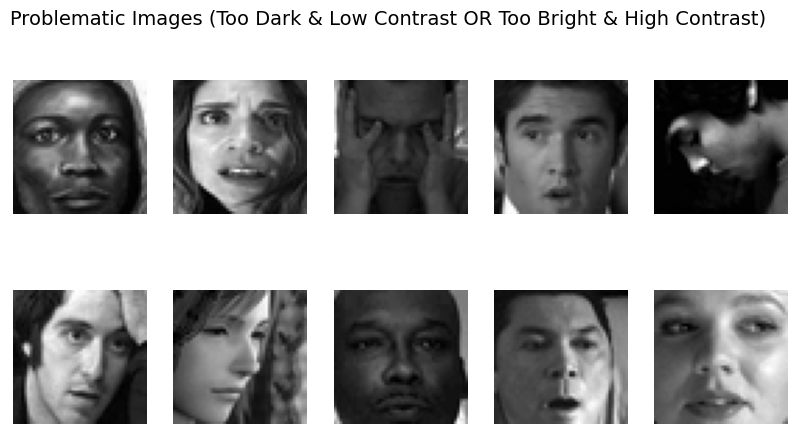

In [10]:
# Define thresholds for problematic images
too_dark_low_contrast = [
    img for img, bright, contrast in zip(train_df['image path'], brightness_values, contrast_values)
    if bright < lower_brightness and contrast < lower_contrast
]

too_bright_high_contrast = [
    img for img, bright, contrast in zip(train_df['image path'], brightness_values, contrast_values)
    if bright > upper_brightness and contrast > upper_contrast
]

# Combine both groups of problematic images
problematic_images = list(set(too_dark_low_contrast) | set(too_bright_high_contrast))

# Print the number of problematic images
print(f"Number of problematic images: {len(problematic_images)}")

# Display the first few problematic images before removal
if len(problematic_images) > 0:
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(problematic_images[:10]):  # Show up to 10 images
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # Arrange in a 2x5 grid
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.suptitle("Problematic Images (Too Dark & Low Contrast OR Too Bright & High Contrast)", fontsize=14)
    plt.show()

train_df = train_df[~train_df['image path'].isin(problematic_images)]

Extracting Image Features:   0%|          | 0/27367 [00:00<?, ?it/s]

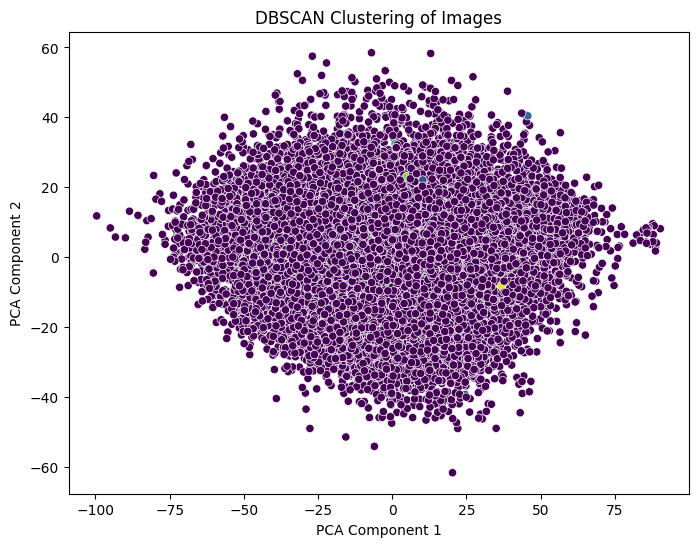

Number of clusters (including noise): 55


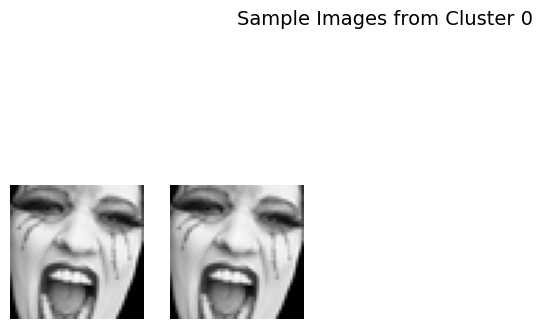

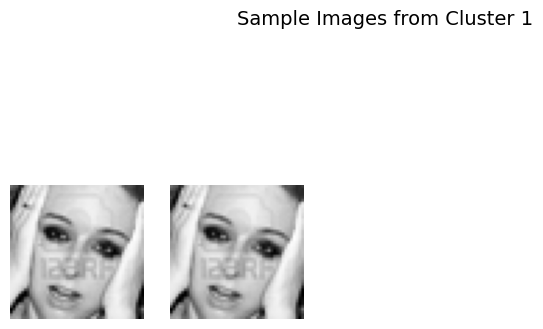

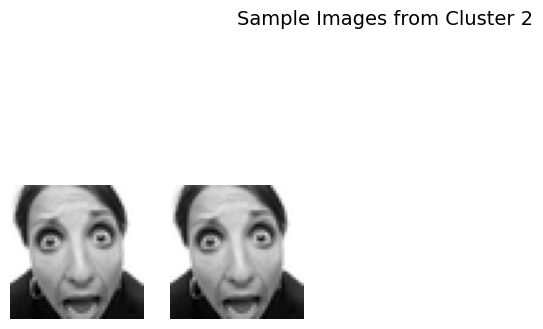

In [11]:
# Extract image features by resizing and flattening
def extract_image_features(image_path):
    img = Image.open(image_path)
    img = img.resize((48, 48))  # Resize to standard size
    return np.array(img).flatten()  # Convert image to 1D array

# Generate feature vectors for all training images
features = np.array([
    extract_image_features(img_path)
    for img_path in tqdm(train_df['image path'], desc="Extracting Image Features")
])

# Standardize the feature vectors
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features_scaled)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=2)
clusters = dbscan.fit_predict(features_pca)

# Assign cluster labels to the DataFrame
train_df["cluster"] = clusters

# Visualize the PCA-reduced features with cluster coloring (no legend)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=clusters, palette="viridis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering of Images")
plt.legend([], [], frameon=False)  # Remove legend
plt.show()

# Count the number of images in each cluster
unique_clusters, counts = np.unique(clusters, return_counts=True)
cluster_summary = dict(zip(unique_clusters, counts))
print(f"Number of clusters (including noise): {len(cluster_summary)}")

# Select a few non-noise clusters for visualization
valid_clusters = [c for c in unique_clusters if c != -1][:3]

# Display a few sample images from each selected cluster
for cluster_id in valid_clusters:
    cluster_images = train_df[train_df["cluster"] == cluster_id]["image path"].tolist()[:5]

    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(cluster_images):
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.suptitle(f"Sample Images from Cluster {cluster_id}", fontsize=14)
    plt.show()

In [12]:
# Find the largest cluster (excluding noise -1)
cluster_counts = dict(zip(*np.unique(clusters, return_counts=True)))
largest_cluster = max(cluster_counts, key=lambda k: cluster_counts[k] if k != -1 else -1)

# Create a new DataFrame to store unique images per cluster
filtered_train_df = pd.DataFrame(columns=train_df.columns)

# Loop through each cluster
for cluster_id in np.unique(clusters):
    cluster_images = train_df[train_df["cluster"] == cluster_id]

    if cluster_id == -1 or cluster_id == largest_cluster:
        # Keep all images in the largest cluster and noise (-1)
        filtered_train_df = pd.concat([filtered_train_df, cluster_images])
    else:
        # Keep only one image per smaller cluster
        filtered_train_df = pd.concat([filtered_train_df, cluster_images.iloc[:1]])

# Reset index after filtering
filtered_train_df = filtered_train_df.reset_index(drop=True)

print(f"Original dataset size: {len(train_df)}")
print(f"Filtered dataset size: {len(filtered_train_df)}")

train_df = filtered_train_df.copy()

Original dataset size: 27367
Filtered dataset size: 27311


# **Pre-processing:**
### In this step, images are pre-processed by applying edge detection (Sobel filter), lighting correction, and sharpening.
### The processed images are then used to extract features, preparing them for model training.
### Afterward, the images are normalized, and labels are encoded using label encoding to convert them into a format suitable for model training.

In [13]:
# Split into 80% train and 20% validation
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['label'])

## HOG - Histogram of Oriented Gradients:

צריך לפרט שאין ולידציה כי משתמש אחר כך ב SVM ולכן סט אימון גדול יותר

In [14]:
# Function to extract HOG features from an image
def extract_hog_features(image_path):
    """
    Extracts HOG features from an image.

    Arguments:
    image_path (str): Path to the image.

    Returns:
    features (ndarray): HOG feature vector.
    """
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize image to a fixed size (ensuring consistency)
    image = cv2.resize(image, (64, 64))

    # Compute HOG features
    features, _ = hog(image,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')

    return features

# Extract HOG features from all images in the dataset
x_train_hog = np.array([extract_hog_features(img_path) for img_path in tqdm(train['image path'], desc="Extracting HOG Features")])
x_test_hog = np.array([extract_hog_features(img_path) for img_path in tqdm(test['image path'], desc="Extracting HOG Features")])

# Print feature shape for confirmation
print(f"HOG feature vector shape: {x_train_hog.shape}")

Extracting HOG Features:   0%|          | 0/28709 [00:00<?, ?it/s]

Extracting HOG Features:   0%|          | 0/7178 [00:00<?, ?it/s]

HOG feature vector shape: (28709, 1764)


In [15]:
# Standardize HOG feature vectors
scaler = StandardScaler()
hog_features_scaled = scaler.fit_transform(x_train_hog)

# Convert labels to integers
le = LabelEncoder()
le.fit(train['label'])

y_train_hog = le.transform(train['label'])
y_test_hog = le.transform(test['label'])

The HOG (Histogram of Oriented Gradients) visualization does not represent the original image but rather the intensity of gradient orientations.

Unlike traditional edge detection methods (such as Sobel or Canny), which highlight sharp boundaries, HOG encodes the direction and strength of gradients within small spatial regions. This results in a blurred or abstract representation of the image rather than a detailed edge map.

The visualization may appear unclear because:

HOG focuses on gradient distributions, not raw pixel values.
Small images (e.g., 48x48) may lose fine details when converted into histograms.
Block normalization smooths the visualization, further abstracting the original features.

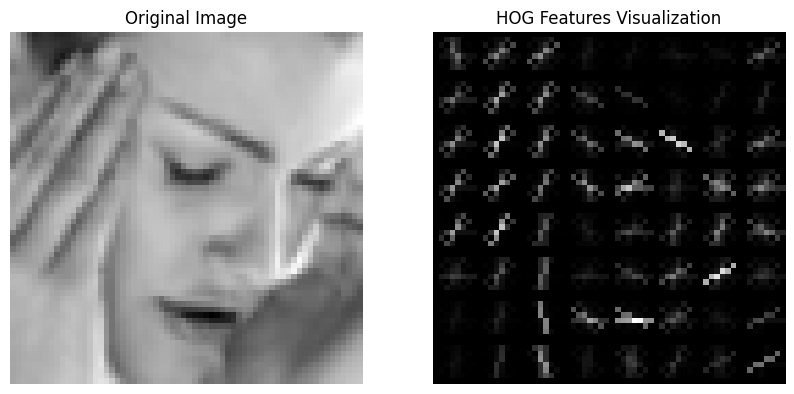

In [16]:
# Function to extract and visualize HOG features
def visualize_hog(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize to ensure consistency
    image = cv2.resize(image, (64, 64))

    # Compute HOG features with visualization
    features, hog_image = hog(image,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              visualize=True,
                              block_norm='L2-Hys')

    # Plot original image and HOG visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow(image, cmap='gray')
    ax1.set_title("Original Image")
    ax1.axis("off")

    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title("HOG Features Visualization")
    ax2.axis("off")

    plt.show()

# Example: Visualizing HOG for a sample image
image_path = train['image path'].iloc[2]  # Take the first image from dataset
visualize_hog(image_path)

## SECN - Sobel Enhanced Contrast Normalization

ללא עיבוד מקדים

In [17]:
# Function to process the image
def process_image(image_path):
    """
    Loads the grayscale image and prepares it for model input without any additional processing.

    Arguments:
    image_path (str): Path to the image.

    Returns:
    image (ndarray): The raw grayscale image.
    """
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

# Function to extract and normalize features from the images
def extract_features(images):
    """
    Extracts raw grayscale images, reshapes, and normalizes them for CNN input.

    Arguments:
    images (list): List of image paths.

    Returns:
    features (ndarray): Array of preprocessed images.
    """
    features = []
    for image in tqdm(images):
        processed_image = process_image(image)
        img = np.array(processed_image).reshape(48, 48, 1)  # Reshape to 48x48x1
        img = img / 255.0  # Normalize pixel values
        features.append(img)

    features = np.array(features)
    return features

# Apply the preprocessing to the full dataset
x_train_regular = extract_features(train_df['image path'])
x_val_regular = extract_features(val_df['image path'])
x_test_regular = extract_features(test['image path'])

  0%|          | 0/22967 [00:00<?, ?it/s]

  0%|          | 0/5742 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

In [18]:
# Convert labels to integers
le = LabelEncoder()
le.fit(train['label'])

y_train_regular = le.transform(train_df['label'])
y_val_regular = le.transform(val_df['label'])
y_test_regular = le.transform(test['label'])

# Convert labels to one-hot encoding
y_train_regular = to_categorical(y_train_regular, num_classes=7)
y_val_regular = to_categorical(y_val_regular, num_classes=7)
y_test_regular = to_categorical(y_test_regular, num_classes=7)

# Configuration settings for model
input_shape = (48, 48, 1)
output_class = 7

עם עיבוד מגקים - סובל וגאוסיאן בלור

In [19]:
# Function to process the image
def process_image(image_path):
    """
    Processes the image by applying Sobel filtering, lighting correction, and sharpening.

    Arguments:
    image_path (str): Path to the image.

    Returns:
    sharpened (ndarray): The processed image.
    """
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Sobel edge filtering
    sobel_image = filters.sobel(image)

    # Lighting correction
    img_corrected = exposure.rescale_intensity(sobel_image, in_range=(0, 1), out_range=(0, 255))

    # Sharpen the image with a Gaussian filter
    sharpened = cv2.GaussianBlur(img_corrected, (5, 5), 0)
    sharpened = cv2.addWeighted(img_corrected, 1.5, sharpened, -0.5, 0)

    return sharpened

# Function to extract features from the images
def extract_features(images):
    """
    Extracts features from the images by processing them.

    Arguments:
    images (list): List of image paths.

    Returns:
    features (ndarray): Array of processed images.
    """
    features = []
    for image in tqdm(images):
        # Process the image before feature extraction
        processed_image = process_image(image)

        # Convert the processed image to an array
        img = np.array(processed_image)
        img = img.reshape(48, 48, 1)  # Reshape the image to 48x48x1
        features.append(img)

    features = np.array(features)
    return features

# Extract features from the datasets
train_features_sobel = extract_features(train_df['image path'])
val_features_sobel = extract_features(val_df['image path'])
test_features_sobel = extract_features(test['image path'])

# Normalize the image data
x_train_sobel = train_features_sobel/255.0
x_val_sobel = val_features_sobel/255.0
x_test_sobel = test_features_sobel/255.0

  0%|          | 0/22967 [00:00<?, ?it/s]

  0%|          | 0/5742 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

In [20]:
y_train_sobel = le.transform(train_df['label'])
y_val_sobel = le.transform(val_df['label'])
y_test_sobel = le.transform(test['label'])

# Convert labels to one-hot encoding
y_train_sobel = to_categorical(y_train_sobel, num_classes=7)
y_val_sobel = to_categorical(y_val_sobel, num_classes=7)
y_test_sobel = to_categorical(y_test_sobel, num_classes=7)

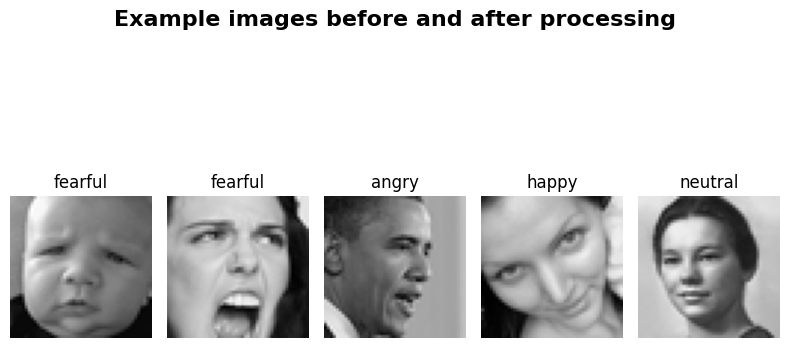

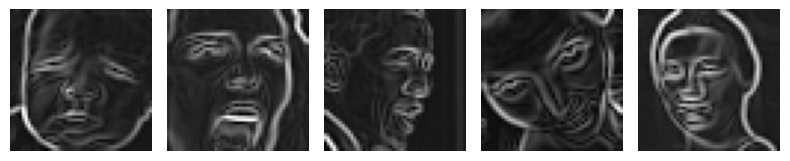

In [21]:
# Display example images before and after processing

num_images_to_display = 5  # Adjust the number of images as needed

# Display original images from the dataset
plt.figure(figsize=(8, 5))  # Smaller figure size
for i in range(min(num_images_to_display, len(train_df))):
    image_path = train_df['image path'].iloc[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(image)
    plt.title(train_df['label'].iloc[i])
    plt.axis('off')

plt.suptitle("Example images before and after processing", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# Display processed images after feature extraction and normalization
plt.figure(figsize=(8, 5))  # Same smaller size as the previous plot
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train_sobel[i].reshape(48, 48), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


# **Model Building and Training:**
### In this step, a Convolutional Neural Network (CNN) is built with multiple convolutional layers, each followed by max-pooling and dropout layers to reduce overfitting.
### The model includes fully connected layers for classification, with a final output layer using the softmax activation function for multi-class classification.
### The model is compiled using the Adam optimizer and categorical cross-entropy loss. It is then trained on the pre-processed image data for 50 epochs, using batch size of 128.

## SVM - Support Vector Machine

In [ ]:
# Define the hyperparameter search space for SVM
param_grid = {
    'C': [0.1, 1, 10],                 # Regularization strength
    'kernel': ['linear', 'rbf'],       # Kernel type: linear or radial basis function (RBF)
    'gamma': ['scale', 'auto']         # Kernel coefficient for RBF
}

# Perform grid search with 3-fold cross-validation
grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the model on the training data
grid.fit(x_train_hog, y_train_hog)

# Output the best found hyperparameters and corresponding accuracy
print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


## CNN - Convolutional Neural Network:

In [ ]:
def build_cnn_model(input_shape=(48, 48, 1), output_class=7):
    """
    Builds and returns a CNN model for emotion classification.

    Parameters:
    - input_shape: tuple, shape of the input images (default: (48, 48, 1))
    - output_class: int, number of output classes (default: 7)

    Returns:
    - model: Compiled Keras Sequential CNN model
    """
    model = Sequential()

    # Convolutional and pooling layers
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))  # (48, 48, 128)
    model.add(MaxPooling2D(pool_size=(2, 2)))  # (24, 24, 128)
    model.add(Dropout(0.4))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))  # (24, 24, 256)
    model.add(MaxPooling2D(pool_size=(2, 2)))  # (12, 12, 256)
    model.add(Dropout(0.4))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))  # (12, 12, 512)
    model.add(MaxPooling2D(pool_size=(2, 2)))  # (6, 6, 512)
    model.add(Dropout(0.4))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))  # (6, 6, 512)
    model.add(MaxPooling2D(pool_size=(2, 2)))  # (3, 3, 512)
    model.add(Dropout(0.4))

    # Flatten and fully connected layers
    model.add(Flatten())  # (3 * 3 * 512 = 4608)
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(output_class, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Set up early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

In [ ]:
# Build and train the model on regular images (without Sobel)
model_regular = build_cnn_model(input_shape, output_class)

history_cnn_regular = model_regular.fit(
    x=x_train_regular,
    y=y_train_regular,
    batch_size=128,
    epochs=100,
    validation_data=(x_val_regular, y_val_regular),
    callbacks=[early_stopping],
    verbose=0
)

In [ ]:
# Build and train the model on Sobel-processed images
model_sobel = build_cnn_model(input_shape, output_class)

history_cnn_sobel = model_sobel.fit(
    x=x_train_sobel,
    y=y_train_sobel,
    batch_size=128,
    epochs=100,
    validation_data=(x_val_sobel, y_val_sobel),
    callbacks=[early_stopping],
    verbose=0
)

## Effnet:

המרת הנתונים ל RGB 224*224

In [ ]:
# Define batch size
batch_size = 16

# Create original TensorFlow datasets from NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_regular, y_train_regular)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_regular, y_val_regular)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_regular, y_test_regular)).batch(batch_size)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import models, layers


# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Make all layers trainable
for layer in base_model.layers:
    layer.trainable = True

# Define the model
model_effnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(output_class, activation='softmax')
])

# Compile
model_effnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Preprocess function for EfficientNet
def preprocess_images_eff(images, labels):
    images_rgb = tf.image.grayscale_to_rgb(images)
    images_resized = tf.image.resize(images_rgb, (224, 224))
    images_preprocessed = preprocess_input(images_resized * 255.0)  # [0, 255] input
    return images_preprocessed, labels

# Apply preprocessing: convert to RGB and resize to 224x224
train_dataset_rgb = train_dataset.map(preprocess_images_eff).prefetch(tf.data.AUTOTUNE)
val_dataset_rgb = val_dataset.map(preprocess_images_eff).prefetch(tf.data.AUTOTUNE)
test_dataset_rgb = test_dataset.map(preprocess_images_eff).prefetch(tf.data.AUTOTUNE)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

# Train
history_effnet = model_effnet.fit(train_dataset_rgb,
                 validation_data=val_dataset_rgb,
                 epochs=20,
                 callbacks=callbacks)

# **Results:**
### In this step, the model's performance is evaluated with several visualizations and metrics.
### Accuracy and loss graphs are plotted for both training and validation
### A confusion matrix is displayed in absolute values and success percentages.
### Key classification metrics (accuracy, F1 score, recall, and precision) are calculated and presented as percentages.
### Additionally, misclassifications are identified and displayed with their prediction scores. For each error, the true and predicted labels, along with the error percentage, are shown.

פונקציה לכל הויזואליזציה

In [ ]:
def plot_accuracy_and_loss(history, model_name='Model'):
    """
    Plots training and validation accuracy and loss over epochs.

    Parameters:
    - history: History object from model.fit()
    - model_name: Optional title prefix
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    # Accuracy plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


def evaluate_model_predictions(y_true, y_pred, label_encoder=None, model_name='Model'):
    """
    Prints classification report and plots confusion matrices (absolute and percentage).

    Parameters:
    - y_true: True labels (integer encoded)
    - y_pred: Predicted labels (integer encoded)
    - label_encoder: LabelEncoder instance (optional, for label names)
    - model_name: Optional title prefix
    """
    if label_encoder:
        labels = label_encoder.inverse_transform(np.unique(y_true))
    else:
        labels = [str(i) for i in np.unique(y_true)]

    # Print accuracy and classification report
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n{classification_report(y_true, y_pred, target_names=labels)}")

    # Confusion matrix (absolute)
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrices
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} - Confusion Matrix (Counts)')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 2, 2)
    sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} - Confusion Matrix (Percentage)')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

## Results of SVM:

In [ ]:
# Predict on the test set
predictions_hog = grid.predict(x_test_hog)

In [ ]:
evaluate_model_predictions(
    y_true=y_test_hog,
    y_pred=predictions_hog,
    label_encoder=le,
    model_name="SVM with HOG"
)

## Results of CNN:

נציג תוצאות עבור CNN ללא סובל

In [ ]:
# Generate predictions from the model on the test set
predictions_regular = model_regular.predict(x_test_regular)

In [ ]:
plot_accuracy_and_loss(history_cnn_regular, model_name="CNN without Sobel")

evaluate_model_predictions(
    y_true = y_test_regular.argmax(axis=1),
    y_pred = predictions_regular.argmax(axis=1),
    label_encoder = le,
    model_name = "CNN without Sobel"
)

עם סובל

In [ ]:
# Generate predictions from the model on the test set
predictions_sobel = model_sobel.predict(x_test_sobel)

In [ ]:
plot_accuracy_and_loss(history_cnn_sobel, model_name="CNN with Sobel")

evaluate_model_predictions(
    y_true=y_test_sobel.argmax(axis=1),
    y_pred=predictions_sobel.argmax(axis=1),
    label_encoder=le,
    model_name="CNN with Sobel"
)

In [ ]:
# Display 10 examples of classification errors for the CNN model using Sobel-processed images

original_labels_sobel = le.inverse_transform(np.arange(7))  # assuming 7 classes
# List to store errors
errors = []

# Identify prediction errors
for i in range(len(predictions_sobel)):
    true_label = y_test_sobel[i].argmax()
    predicted_label = predictions_sobel[i].argmax()
    if true_label != predicted_label:
        errors.append((i, true_label, predicted_label, predictions_sobel[i]))  # (index, true label, predicted label, prediction scores)

# Display 10 errors from index 10 to 19
for i in range(1,3000,300):
    index, true_label, predicted_label, prediction_scores = errors[i]
    # Create a plot
    plt.figure(figsize=(6, 4))

    # Display the Sobel-processed image
    plt.subplot(1, 2, 1)
    plt.imshow(x_test_sobel[index].reshape(48, 48), cmap='gray')
    plt.title(f"True: {original_labels_sobel[true_label]}\nPredicted: {original_labels_sobel[predicted_label]}")
    plt.axis('off')

    # Display the original image
    original_image_path = test['image path'].iloc[index]
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 2, 2)
    plt.imshow(original_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Display prediction scores for all emotions
    print("Prediction scores:")
    for j, score in enumerate(prediction_scores):
        emotion = original_labels_sobel[j]
        print(f"{emotion}: {score:.4f}")

    true_score = prediction_scores[true_label]
    predicted_score = max(prediction_scores)

    print(f"\nHighest prediction score: {predicted_score:.4f}")
    error_percentage = abs(true_score - predicted_score)
    print(f"Error (difference between true and predicted scores): {error_percentage:.4f}")
    print("-----------------------------------------------------------------------------\n")


## Results of Effnet

In [ ]:
# Safe prediction loop: go batch by batch and match each prediction with its true label
y_true = []
y_pred = []

for images, labels in test_dataset_rgb:
    preds = model_effnet.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # one-hot to int

y_true = np.array(y_true)
y_pred = np.array(y_pred)


# Evaluate
plot_accuracy_and_loss(history_effnet, model_name="Effnet without Sobel")
evaluate_model_predictions(
    y_true=y_true,
    y_pred=y_pred,
    label_encoder=le,
    model_name="Effnet without Sobel"
)


# Emotion recognition on my images

In [ ]:
!wget -O deepfaceemotion.zip https://github.com/Ido11118/DeepFaceEmotion/archive/refs/heads/main.zip
!unzip -o deepfaceemotion.zip -d /content/
image_path = "/content/DeepFaceEmotion-main/emotion photos"

In [ ]:
# Function to crop the face from an image using Haar cascades
def crop_face(image):
    image_rgb = np.array(image)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_image = gray[y:y+h, x:x+w]
        return face_image
    else:
        return gray  # Return grayscale image if no face is detected

# Load and prepare image: crop face and resize to 48x48
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image_gray = crop_face(image)
    image_resized = cv2.resize(image_gray, (48, 48), interpolation=cv2.INTER_LANCZOS4)
    image_array = np.array(image_resized)
    return image_array, image

# Apply Sobel edge filtering, lighting correction, and sharpening
def process_image(image_array):
    sobel_image = filters.sobel(image_array)
    img_corrected = exposure.rescale_intensity(sobel_image, in_range=(0, 1), out_range=(0, 255))
    sharpened = cv2.GaussianBlur(img_corrected, (5, 5), 0)
    sharpened = cv2.addWeighted(img_corrected, 1.5, sharpened, -0.5, 0)
    return sharpened

# Plot original, grayscale, and processed images
def display_images(original, gray, processed):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Image (Color)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Cropped Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(processed, cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')

    plt.show()

# Predict the emotion using a trained model
def predict_emotion(image_array):
    image_array = image_array / 255.0
    image_array = image_array.reshape(1, 48, 48, 1)
    predictions = model_sobel.predict(image_array)
    labels = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]
    predicted_label = np.argmax(predictions, axis=1)[0]
    predicted_label_name = labels[predicted_label]

    # Print scores for all emotion labels
    print("Prediction Scores:")
    for i, label in enumerate(labels):
        print(f"{label}: {predictions[0][i]:.4f}")

    return predicted_label_name, predictions


# Process all images in a given directory and collect results
def process_directory(directory_path):
    true_labels = []
    predicted_labels = []

    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file)
            true_label = file.split()[0]  # Extract label from filename
            img_array, img_original = load_and_preprocess_image(file_path)
            img_gray = crop_face(Image.open(file_path))
            img_processed = process_image(img_array)
            predicted_label, predictions = predict_emotion(img_processed)

            # Save results
            true_labels.append(true_label)
            predicted_labels.append(predicted_label)

            # Print both true and predicted labels
            correct = "✅" if true_label == predicted_label else "❌"
            print(f"True Label: {true_label} | Predicted: {predicted_label} {correct}")

            display_images(img_original, img_array, img_processed)
            print("-" * 80)

    return true_labels, predicted_labels

# Run on directory
true_labels, predicted_labels = process_directory(image_path)

In [ ]:
# כל הקטגוריות האפשריות לפי ה-LabelEncoder
all_labels = le.classes_

# Create DataFrame
results_df = pd.DataFrame({
    "True": true_labels,
    "Predicted": predicted_labels
})

# Confusion Matrix - include all labels as index and columns
conf_matrix = pd.crosstab(
    results_df["True"],
    results_df["Predicted"],
    rownames=["True"],
    colnames=["Predicted"],
    dropna=False
).reindex(index=all_labels, columns=all_labels, fill_value=0)

# Plot heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report (force all labels to appear)
print("Classification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    labels=range(len(all_labels)),
    target_names=all_labels,
    zero_division=0  # To handle cases with no predictions for a class
))


.
.

*   List item

*   List item

*   List item

*   List item

*   List item

*   List item

*   List item
*   List item


*   List item


*   List item


*   List item


*   List item


*   List item


*   List item


.
.
.

.
.
.
.
.
.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as effnet_preprocess

# רגשות לפי הסדר של המודל
emotion_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# נתיב לתיקיית התמונות
image_path = "/content/DeepFaceEmotion-main/emotion photos"

# טוען את קובץ הזיהוי פנים מ־OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def load_and_preprocess_image(img_path):
    original = cv2.imread(img_path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print(f"⚠️ לא זוהו פנים בתמונה: {img_path}")
        return None, None

    (x, y, w, h) = faces[0]

    size = max(w, h)
    center_x, center_y = x + w // 2, y + h // 2
    x_new = max(center_x - size // 2, 0)
    y_new = max(center_y - size // 2, 0)
    cropped = original_rgb[y_new:y_new+size, x_new:x_new+size]

    resized = cv2.resize(cropped, (224, 224))

    print(f"📷 [{os.path.basename(img_path)}] Pixel range BEFORE preprocess: min={resized.min()}, max={resized.max()}")

    img_array = effnet_preprocess(resized.astype(np.float32))

    print(f"📷 [{os.path.basename(img_path)}] Pixel range AFTER preprocess: min={img_array.min():.3f}, max={img_array.max():.3f}")

    return original_rgb, img_array

def predict_and_display(image_dir, model):
    files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    for fname in files:
        label = fname.split()[0].lower()
        img_path = os.path.join(image_dir, fname)

        original, processed = load_and_preprocess_image(img_path)
        if original is None:
            continue

        input_tensor = np.expand_dims(processed, axis=0)

        preds = model.predict(input_tensor, verbose=0)[0]
        pred_label_idx = np.argmax(preds)
        pred_label = emotion_labels[pred_label_idx]

        # תצוגה
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(original)
        axes[0].set_title("Original")
        axes[0].axis('off')

        # נורמליזציה אוטומטית לצורך הצגה
        vis_img = (processed - processed.min()) / (processed.max() - processed.min())
        axes[1].imshow(vis_img)
        axes[1].set_title("Processed")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        print("🔍 הסתברויות רגשות:")
        for i, emotion in enumerate(emotion_labels):
            print(f"- {emotion:10}: {preds[i]:.3f}")

        correct = (label == pred_label)
        print(f"\n תווית אמיתית: {label}")
        print(f" תחזית המודל: {pred_label}")
        print(f"{'✅ נכון' if correct else '❌ לא נכון'}")
        print("-" * 40)

# להריץ
predict_and_display(image_path, model_effnet)
